In [5]:
import os
import csv
import sqlite3

# Connecting to SQLite database
conn = sqlite3.connect('bank_customers.db')
cursor = conn.cursor()

# Creating tables
cursor.execute('''CREATE TABLE IF NOT EXISTS numerical_data (
                    id INTEGER PRIMARY KEY,
                    CreditScore INTEGER,
                    Age INTEGER,
                    Tenure INTEGER,
                    Balance REAL,
                    NumOfProducts INTEGER,
                    HasCrCard INTEGER,
                    IsActiveMember INTEGER,
                    EstimatedSalary REAL
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS categorical_data (
                    id INTEGER PRIMARY KEY,
                    Geography TEXT,
                    Gender TEXT
                )''')

cursor.execute('''CREATE TABLE IF NOT EXISTS target_data (
                    id INTEGER PRIMARY KEY,
                    LeftBank INTEGER
                )''')
# Inserting data into tables
with open(r'BankCustomers_ChurnModeling.csv', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        numerical_data = (row['CreditScore'], row['Age'], row['Tenure'], row['Balance'], row['NumOfProducts'], row['HasCrCard'], row['IsActiveMember'], row['EstimatedSalary'])
        cursor.execute('''INSERT INTO numerical_data (CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary) VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', numerical_data)
        numerical_id = cursor.lastrowid
        
        categorical_data = (row['Geography'], row['Gender'])
        cursor.execute('''INSERT INTO categorical_data (Geography, Gender) VALUES (?, ?)''', categorical_data)
        categorical_id = cursor.lastrowid
        
        target_data = (row['LeftBank'],)
        cursor.execute('''INSERT INTO target_data (LeftBank) VALUES (?)''', target_data)
        target_id = cursor.lastrowid

conn.commit()
conn.close()


In [6]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

conn = sqlite3.connect('bank_customers.db')

# Joining numerical, categorical, and target tables
query = '''
SELECT n.*, c.Geography, c.Gender, t.LeftBank
FROM numerical_data n
JOIN categorical_data c ON n.id = c.id
JOIN target_data t ON n.id = t.id
'''
# Creating DataFrame
data = pd.read_sql(query, conn)
conn.close()


In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
data.head()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,LeftBank
0,1,619,42,2,0.00,1,1,1,101348.88,France,Female,1
1,2,608,41,1,83807.86,1,0,1,112542.58,Spain,Female,0
2,3,502,42,8,159660.80,3,1,0,113931.57,France,Female,1
3,4,699,39,1,0.00,2,0,0,93826.63,France,Female,0
4,5,850,43,2,125510.82,1,1,1,79084.10,Spain,Female,0


In [9]:
data = data.drop('id', axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      80000 non-null  int64  
 1   Age              80000 non-null  int64  
 2   Tenure           80000 non-null  int64  
 3   Balance          80000 non-null  float64
 4   NumOfProducts    80000 non-null  int64  
 5   HasCrCard        80000 non-null  int64  
 6   IsActiveMember   80000 non-null  int64  
 7   EstimatedSalary  80000 non-null  float64
 8   Geography        80000 non-null  object 
 9   Gender           80000 non-null  object 
 10  LeftBank         80000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 6.7+ MB


**There are no null values present in the dataset**

In [12]:
data.dtypes

CreditScore          int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Geography           object
Gender              object
LeftBank             int64
dtype: object

In [13]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,LeftBank
count,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,650.52880,38.921800,5.012800,76485.889288,1.530200,0.705500,0.515100,100090.239881,0.203700
std,96.64907,10.487348,2.892048,62394.675222,0.581629,0.455821,0.499775,57507.976647,0.402751
min,350.00000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.00000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,652.00000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,718.00000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500,0.000000
max,850.00000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
# !pip install ydata-profiling

In [14]:
from ydata_profiling import ProfileReport
profile = ProfileReport(data, title = "Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Credit Score:
The 'CreditScore' data spans from 350 to 850 with a mean score of approximately 650. The histogram shows a nearly normal distribution but with a notable spike at the higher end, possibly indicating an outlier or data error at maximum values analyzing credit score data, as they can influence the interpretation of creditworthiness distributions and risk assessments.**

**Age:
The data summary for the 'Age' variable shows it ranges from 18 to 92 with a mean age of approximately 38. The distribution is skewed right, indicating a higher concentration of younger individuals in the dataset.**

**Tenure:
The 'Tenure' variable shows values ranging from 0 to 10 years with an average tenure of approximately 5 years. The histogram reveals a fairly uniform distribution across most tenure lengths, but there is a noticeable decrease for the maximum value of 10 years.**

**Balance:
The 'Balance' variable ranges from 0 to approximately 250,898, with a mean balance of around 76,486. Over one-third of the entries (36.2%) are zeros, suggesting a significant portion of accounts might be inactive or newly opened.**

**NumofProducts:
NumOfProducts, most individuals have 1 or 2 products, with a significant drop in those having 3 or 4 products.**

**HasCrCard:
HasCrCard, a majority of the dataset's individuals, approximately 71%, possess a credit card**

**Estimated Salary:
The 'EstimatedSalary' variable is widely distributed between $11.58 and $199,992.48, with a mean salary of about $100,090. The histogram shows a relatively uniform distribution across different salary ranges, suggesting diverse income levels among the dataset's subjects.**


<Axes: xlabel='salary_cat'>

Text(0.5, 1.0, 'Salary Categories Distribution Based on Standard Deviation')

Text(0.5, 0, 'Salary Category')

Text(0, 0.5, 'Number of Customers')

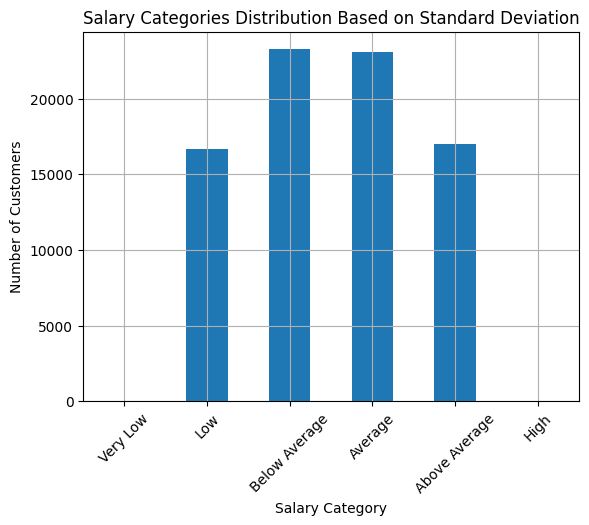

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mean_salary = data['EstimatedSalary'].mean()
std_salary = data['EstimatedSalary'].std()

bins = [
    -np.inf,                         
    mean_salary - (2 * std_salary),    
    mean_salary - std_salary,          
    mean_salary,                       
    mean_salary + std_salary,          
    mean_salary + (2 * std_salary),    
    np.inf                             
]
labels = ['Very Low', 'Low', 'Below Average', 'Average', 'Above Average', 'High']

# Creating a new column 'salary_cat' by categorizing the 'EstimatedSalary' 
data["salary_cat"] = pd.cut(data["EstimatedSalary"], bins=bins, labels=labels, include_lowest=True)

# Displaying the counts of each category
salary_counts = data["salary_cat"].value_counts().sort_index()
salary_counts.plot.bar(rot=45, grid=True)
plt.title("Salary Categories Distribution Based on Standard Deviation")
plt.xlabel("Salary Category")
plt.ylabel("Number of Customers")
plt.show()



**17,500 customers, while "Above Average" and "Low" categories have around 12,500 customers each. The "Very Low" and "High" salary categories have negligible or no representation.**

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, stratify=data['salary_cat'], random_state=42)

In [17]:
## Checking stratification
train['salary_cat'].value_counts() / len(train['salary_cat'])
test['salary_cat'].value_counts() / len(test['salary_cat'])

salary_cat
Below Average    0.290607
Average          0.288304
Above Average    0.212393
Low              0.208696
Very Low         0.000000
High             0.000000
Name: count, dtype: float64

salary_cat
Below Average    0.290583
Average          0.288292
Above Average    0.212417
Low              0.208708
Very Low         0.000000
High             0.000000
Name: count, dtype: float64

Both Train and Test sets follows same distribution

In [18]:
train.drop('salary_cat', axis =1, inplace = True)
test.drop('salary_cat', axis =1, inplace = True)

In [19]:
train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,LeftBank
60476,605,31,1,117992.59,1,1,1,183598.77,Germany,Female,0
74598,638,46,9,139859.54,1,1,0,38967.29,France,Male,0
72346,518,46,4,113625.93,1,0,0,92727.42,Germany,Male,1
55106,600,32,1,78535.25,1,1,0,64349.60,France,Female,0
47954,743,30,7,77599.23,1,0,0,144407.10,France,Male,0


In [20]:
corr_matrix = train.corr(numeric_only=True)
corr_matrix['LeftBank'].sort_values(ascending=False)

LeftBank           1.000000
Age                0.283949
Balance            0.116014
EstimatedSalary    0.012339
HasCrCard         -0.004006
Tenure            -0.015709
CreditScore       -0.029245
NumOfProducts     -0.047340
IsActiveMember    -0.158531
Name: LeftBank, dtype: float64

Text(0.5, 1.0, 'Correlation Plot')

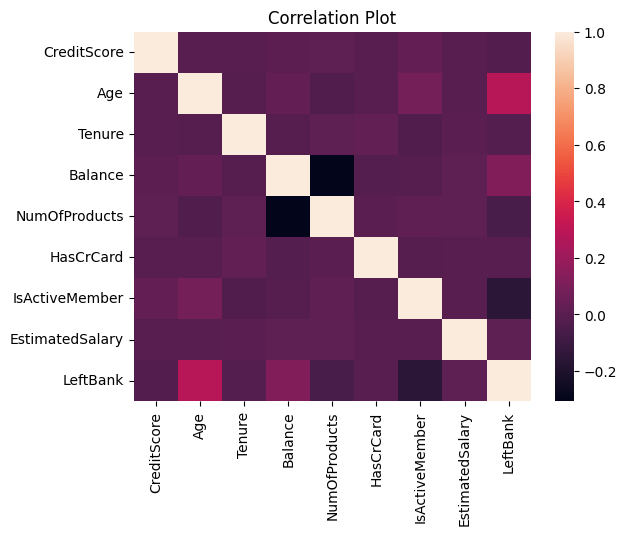

In [32]:
import seaborn as sns 
sns.heatmap(train.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')

**The correlation plot shows the pairwise correlations between different variables such as Credit Score, Age, Tenure, Balance, etc. Dark purple indicates a negative correlation, light shades indicate low to no correlation, and pink/red indicates positive correlation; for example, there's a significant negative correlation between Age and LeftBank, and a positive correlation between NumOfProducts and Balance.**

Text(0.5, 1.0, 'Customer Churn Analysis')

<Axes: title={'center': 'Customer Churn Analysis'}, xlabel='Geography', ylabel='LeftBank'>

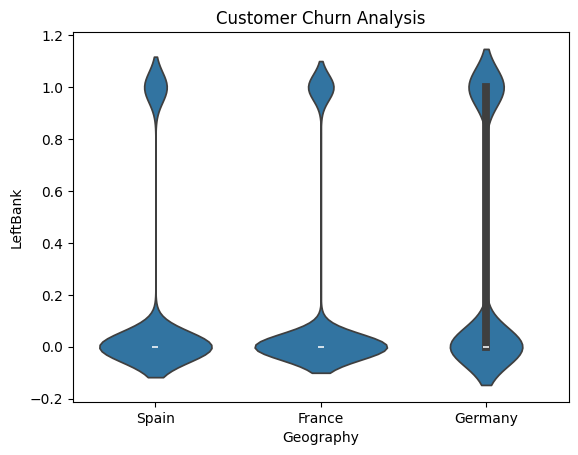

In [33]:
plt.title('Customer Churn Analysis')
sns.violinplot(x='Geography', y='LeftBank', data=train)
plt.show()

**The violin plot represents customer churn ("LeftBank") across three countries: Spain, France, and Germany. Churn appears relatively similar in Spain and France, while Germany shows a wider range of churn, indicating higher variability or possibly different customer behaviors in this market.**

Text(0.5, 1.0, 'Customer Churn Analysis')

<Axes: title={'center': 'Customer Churn Analysis'}, xlabel='Gender', ylabel='LeftBank'>

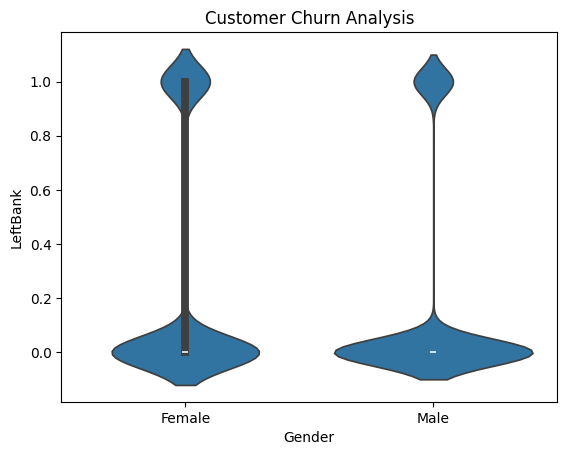

In [34]:
plt.title('Customer Churn Analysis')
sns.violinplot(x='Gender', y='LeftBank', data=train)
plt.show()

**The violin plot illustrates the distribution of customer churn ("LeftBank") by gender. Churn rates are higher and more varied among male customers compared to female customers, who show a narrower and lower range of churn.**

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train our custom preprocessors 
    numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary' ]
    categorical_columns = ['Geography', 'Gender' ]
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equiv
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [22]:
preprocessor = Preprocessor()
preprocessor.fit(train)
train_fixed = preprocessor.transform(train)

Preprocessor()

In [23]:
train_fixed

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,LeftBank,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
60476,-0.470661,-0.752278,-1.385782,0.664636,-0.909558,0.646480,0.972173,1.451246,0,0,1,0,1,0
74598,-0.129337,0.679519,1.380262,1.014928,-0.909558,0.646480,-1.028624,-1.062666,0,1,0,0,0,1
72346,-1.370517,0.679519,-0.348515,0.594686,-0.909558,-1.546837,-1.028624,-0.128234,1,0,1,0,0,1
55106,-0.522377,-0.656825,-1.385782,0.032559,-0.909558,0.646480,-1.028624,-0.621483,0,1,0,0,1,0
47954,0.956696,-0.847731,0.688751,0.017565,-0.909558,-1.546837,-1.028624,0.770036,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61638,0.501596,0.011347,1.380262,-1.225516,-0.909558,0.646480,-1.028624,-0.332702,0,1,0,0,0,1
69700,-0.905074,-0.275012,-0.348515,1.076137,0.806531,0.646480,0.972173,-0.635708,0,0,0,1,1,0
70229,-0.584436,-0.943185,-0.694271,0.870285,-0.909558,0.646480,-1.028624,-0.678861,0,0,1,0,1,0
28785,2.063415,-1.134091,-1.385782,0.396885,0.806531,0.646480,0.972173,-1.283447,0,0,1,0,0,1


In [24]:
train_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 60476 to 47647
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        56000 non-null  float64
 1   Age                56000 non-null  float64
 2   Tenure             56000 non-null  float64
 3   Balance            56000 non-null  float64
 4   NumOfProducts      56000 non-null  float64
 5   HasCrCard          56000 non-null  float64
 6   IsActiveMember     56000 non-null  float64
 7   EstimatedSalary    56000 non-null  float64
 8   LeftBank           56000 non-null  int64  
 9   Geography_France   56000 non-null  int32  
 10  Geography_Germany  56000 non-null  int32  
 11  Geography_Spain    56000 non-null  int32  
 12  Gender_Female      56000 non-null  int32  
 13  Gender_Male        56000 non-null  int32  
dtypes: float64(8), int32(5), int64(1)
memory usage: 5.3 MB


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
rfr = make_pipeline(Preprocessor(), RandomForestRegressor(n_estimators = 100, max_depth = 5 ))
rfr

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor', RandomForestRegressor(max_depth=5))])

In [26]:
params = rfr.get_params()
params

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestregressor', RandomForestRegressor(max_depth=5))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestregressor': RandomForestRegressor(max_depth=5),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': 5,
 'randomforestregressor__max_features': 1.0,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__monotonic_cst': None,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'randomfores

In [27]:
train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,LeftBank
60476,605,31,1,117992.59,1,1,1,183598.77,Germany,Female,0
74598,638,46,9,139859.54,1,1,0,38967.29,France,Male,0
72346,518,46,4,113625.93,1,0,0,92727.42,Germany,Male,1
55106,600,32,1,78535.25,1,1,0,64349.60,France,Female,0
47954,743,30,7,77599.23,1,0,0,144407.10,France,Male,0


In [28]:
y_train = train['LeftBank']
X_train = train.drop('LeftBank', axis = 1)

rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor', RandomForestRegressor(max_depth=5))])

In [29]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
y_train_hat = rfr.predict(X_train)
root_mean_squared_error(y_train, y_train_hat)
mean_absolute_error(y_train, y_train_hat)

0.32119863755165495

0.2104976206697125

In [30]:
y_test = test['LeftBank']
X_test = test.drop('LeftBank', axis = 1)

In [31]:
y_test_hat = rfr.predict(X_test)
rm2e = root_mean_squared_error(y_test, y_test_hat)
mae = mean_absolute_error(y_test, y_test_hat)

In [32]:
rm2e

0.3235198462843198

In [33]:
mae

0.21208310037223532

In [65]:
import mlflow
from mlflow.models import infer_signature

#set our tracking server
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#create a new MLflow Experiment
mlflow.set_experiment("Predict Bank Customer Churn")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("root_mean_squared_error", rm2e)
    mlflow.log_metric("mean_absolute_error", mae)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "RandomForestRegressor model for customer churn data n_estimators = 100 and max_depth = 5")

    # Infer the model signature
    signature = infer_signature(X_train, rfr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfr,
        artifact_path="customer_churn_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="rfr_model_n_estimators = 100 and max_depth = 5",
    )

<Experiment: artifact_location='mlflow-artifacts:/267518694512143709', creation_time=1715799718243, experiment_id='267518694512143709', last_update_time=1715799718243, lifecycle_stage='active', name='Predict Bank Customer Churn', tags={}>

C:\Users\prudh\.conda\envs\mproject\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'rfr_model_n_estimators = 100 and max_depth = 5'.
2024/05/15 17:22:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rfr_model

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, roc_auc_score, confusion_matrix)

lr = make_pipeline(Preprocessor(), LogisticRegression(solver = 'liblinear'))
lr

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [87]:
lrparams = lr.get_params()
lrparams

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('logisticregression', LogisticRegression(solver='liblinear'))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'logisticregression': LogisticRegression(solver='liblinear'),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [88]:
y_train = train['LeftBank']
X_train = train.drop('LeftBank', axis = 1)

lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [89]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
y_train_hat = lr.predict(X_train)
accuracy_score(y_train, y_train_hat)
balanced_accuracy_score(y_train, y_train_hat)
f1_score(y_train, y_train_hat)
precision_score(y_train, y_train_hat)
recall_score(y_train, y_train_hat)
roc_auc_score(y_train, y_train_hat)
confusion_matrix(y_train, y_train_hat)


0.8105

0.5894378275855838

0.31746848469256495

0.5978682170542635

0.21611208406304727

0.5894378275855838

array([[32190,  1245],
       [ 6714,  1851]], dtype=int64)

In [90]:
y_test = test['LeftBank']
X_test = test.drop('LeftBank', axis = 1)

In [91]:
y_test_hat = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_test_hat)
b_accuracy = balanced_accuracy_score(y_test, y_test_hat)
f1 = f1_score(y_test, y_test_hat)
precision = precision_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
roc = roc_auc_score(y_test, y_test_hat)
cm = confusion_matrix(y_test, y_test_hat)

In [92]:
recall

0.21575061525840852

In [93]:
import mlflow
from mlflow.models import infer_signature

#set our tracking server
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#create a new MLflow Experiment
mlflow.set_experiment("Predict Bank Customer Churn")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("accuracy_score", accuracy)
    mlflow.log_metric("balanced_accuracy_score", b_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision_score", precision)
    mlflow.log_metric("recall_score", recall)
    mlflow.log_metric("roc_auc_score", roc)
    #mlflow.log_metric("confusion_matrix", cm)
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "LogisticRegressor model for customer churn data with Solver = liblinear and max_iter = 100")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="customer_churn_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="lr_model_solver=liblinear",
    )


<Experiment: artifact_location='mlflow-artifacts:/267518694512143709', creation_time=1715799718243, experiment_id='267518694512143709', last_update_time=1715799718243, lifecycle_stage='active', name='Predict Bank Customer Churn', tags={}>

C:\Users\prudh\.conda\envs\mproject\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lr_model_solver=liblinear'.
2024/05/15 18:57:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lr_model_solver=liblinear, ver

In [36]:
options = {}
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts',   'EstimatedSalary']
for column in numerical_columns:
    options[column] = (X_train[column].min(),  X_train[column].max())
#we considered HasCreditCard and IsActiveMember variables as categorical to get as dropdown in streamlit
for column in ['HasCrCard','IsActiveMember','Geography', 'Gender']:
    options[column] = sorted(X_train[column].unique().tolist())
options

{'CreditScore': (350, 850),
 'Age': (18, 92),
 'Tenure': (0, 10),
 'Balance': (0.0, 250898.09),
 'NumOfProducts': (1, 4),
 'EstimatedSalary': (11.58, 199992.48),
 'HasCrCard': [0, 1],
 'IsActiveMember': [0, 1],
 'Geography': ['France', 'Germany', 'Spain'],
 'Gender': ['Female', 'Male']}

In [39]:
import json

for key, value in options.items():
    if isinstance(value, tuple):
        options[key] = tuple(float(val) if isinstance(val, np.int64) else val for val in value)
    elif isinstance(value, list):
        options[key] = [int(val) if isinstance(val, np.int64) else val for val in value]

# Now serializing
with open('input_options.json', 'w') as file:
    json.dump(options, file, indent=2)